<h1> Project 1: Lane Detection </h1>
<ul>Tools are my disposal:
<li>Color_selection</li>
<li>Region of interest selection</li>
<li>Grayscaling</li>
<li>Gaussian Smoothing</li>
<li>Canny edge detection</li>
<li>Hough Transform line detection</li>
</ul>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
%load_ext autoreload

%autoreload 2

In [4]:
import os
images = os.listdir("test_images/")
print('images: ', images)

images:  ['whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg', 'solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg']


In [5]:
#reading in an image
def readImage(image):
    image = mpimg.imread('test_images/' + image)
    gray = grayscale(image)
    blur_gray = apply_gaussian_blur(gray)
    edges = apply_canny(blur_gray)
    masked_image = apply_mask(edges, image, gray)
    hough_image, lines = apply_hough(masked_image)
    lines_edges_weighted = apply_lines_edges_weighted(image, edges, hough_image)
    plot_mask(edges, image, masked_image)
    plot_hough(hough_image, lines)
    plot_mask_and_hough(masked_image, hough_image)
    plot_weighted_image(lines_edges_weighted)
    return lines_edges_weighted
#         cv2.cvtColor(lines_edges_weighted, 'writer.jpg', 8)
#         print('writer: ', writer.shape)
#         print('writer: ', writer.dtype)
#         cv2.imwrite('results/'+ image + ".jpg", lines_edges_weighted)

# Read in one image and output the result
def readAllImages(images):
    for img in images:
        result = readImage(img)
        mpimg.imsave('results_rendered/' + '-ChangedParameters--'+img, result)


When we convert the image to grayscale we simply take off the RGB values and provide 1 value instead.
<li>Shape of image: (960, 540, 3)</li>
<li>Shape of gray: (960, 540)</li>
No 3rd dimension on Grayscale

We then provide a Gaussian Blur to reduce noise/detail from the image. This process is the same as convolving the image with a Gaussian function. It smoothes out the edges.
<li>Shape of gray: (540, 960)</li>
<li>Shape of blur_gray: (540, 960)</li>
<li>Gaussian Blur also takes in a kernel_size. A larger kernel_size implies averaging over a larger area. They must be odd, typically 3 or 5 work well.</li>
<li> A ratio of 1:2 or 1:3 Low:High threshold is recommended.</li>


In [6]:
# Gaussian Blur
def apply_gaussian_blur(gray, kernel_size = 5):
    return gaussian_blur(gray, kernel_size)

Next we define parameters for the Canny function, which will take in an image, a low_threshold, and a high_threshold
<li>pixel values below low_threshold are discarded</li>
<li>pixel values above high_threshold are considered to be edges</li>
<li>pixel values between low and high thresholds are kept if they are touching a pixel above high threshold (edges)</li>

<h3>Canny Input</h3><h5>blur_gray (shape: (540,960)</h5>
<h3>Canny Output</h3><h5>edges (shape:(540, 960) </h5>


In [7]:
# Define Parameters for Canny
def apply_canny(blur_gray, low_threshold = 50, high_threshold = 150):
# Use a 1:3 ratio
#     low_threshold = 50
#     high_threshold = 150


# Apply Canny, changes pixel values to be either 0 (black) or 255 (white)
    return canny(blur_gray, low_threshold, high_threshold)
# print('edges shape: ', edges.shape)
# print('white edges : ', np.where(edges > 0))
# print('white edge values : ', edges[np.where(edges > 0)]) #all 255

<h3>Image Mask / Region of interest</h3>
<p>Next we wish to apply an image mask to only consider lane lines in a surrounding polygon</p>
<p>Here we will use the <strong>cv2.fillPoly(mask, vertices, ignore_mask_color) function </strong></p>
<li>Input edges shape: (540, 960) Output: masked Image shape: (540, 960) </li>
<li>Function does not change input 'edges'</li>

In [8]:
def apply_mask(edges, image, gray):
    #make general shape of mask
    mask = np.zeros_like(edges)
    # create ignore mask color = 255
    ignore_mask_color = 255 

    # create vertices for region
    imshape = image.shape

#     apex_left = [430, 327]
#     apex_right = [imshape[1] - 420, 327]
#     bottom_left = [130, imshape[0]]
#     bottom_right = [imshape[1] - 39,imshape[0]]
    
    # Modified vertices
#     apex_left = [450, 327]
#     apex_right = [imshape[1] - 420, 327]
#     bottom_left = [175, imshape[0]]
#     bottom_right = [imshape[1] - 39,imshape[0]]
    
    # Short and fat
    apex_left = [400, 355]
    apex_right = [imshape[1] - 380, 355]
    bottom_left = [175, imshape[0]]
    bottom_right = [imshape[1] - 39,imshape[0]]
    
    
    # CHANGE VERTICES FOR BETTER ACCURACY
    # vertices = np.array([[(115,imshape[0]),(465, 317), (imshape[1]-465, 317), (imshape[1] -60,imshape[0])]], dtype=np.int32)
    vertices = np.array([[(bottom_left[0],bottom_left[1]), \
                          (apex_left[0],apex_left[1]), \
                          (apex_right[0], apex_right[1]), \
                          (bottom_right[0], bottom_right[1])]], dtype=np.int32)
    

    # Polyfill the mask and do a bitwise_and to keep only edges in the region
    (masked_image, mask) = region_of_interest(edges, vertices)

    #Mask and image:
#     masked_edges = cv2.bitwise_or(mask, gray)
    return masked_image

def plot_mask(edges, image, masked_image):
    # PLOT
    fig = plt.figure()

    a = fig.add_subplot(3,1,1)
    edgeplot = plt.imshow(edges, cmap="gray")
    a.set_title('Edges')

    a = fig.add_subplot(3,1,2)
    a.set_title('Image')
    edgeplot = plt.imshow(image)

    a = fig.add_subplot(3,1,3)
    a.set_title('Masked Image')
    edgeplot = plt.imshow(masked_image, cmap="gray")
    plt.show()


<h3>Hough Lines</h3>
<li>Now that we have masked image Shape: (540, 960). We can use <strong>lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)</strong> to get a row vector of our lines</li>
<li>Copy the image to draw on <strong>line_image</strong> (row vecto with (x1,y1,x2,y2) as elements).</li>
<li>Iterate through the rows of lines, then grab each element (x1, y1, x2, and y2) and use <strong>cv2.line(<strong>line_image</strong>, pt1, pt2, color, thickness)</strong> to draw lines</li>

In [9]:
def apply_hough(masked_image):
    rho = 1 
    theta = np.pi/180 
    threshold = 50
    # Adjust min_line_len from 5 to 50
    # Adjust max_line_gap from 1 to 200
    # Adjust threshold from 5 to 50
    min_line_len = 50
    max_line_gap = 200

    # Create a line image with hough lines on it
    hough_image, lines = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)

#     print('lines: ', lines.shape)
    # line_zero[:,1,0] = lines[:,1,0]

    return hough_image, lines
    # We gave line_image color when we copied the shape of mask_image and then added a 3rd dimension for our color space.
    # Then in draw_lines we input color = [255, 0, 0] so that will be red in this case. 
    # I changed the input color in draw_lines to [0, 255, 0] so we get green 
#     print('line shape: ', lines.shape)
#     print('hough image shape: ', hough_image.shape)
#     print('lines shape: ', lines.shape)
    
def plot_hough(hough_image, lines):
    fig = plt.figure()

    b = fig.add_subplot(2,1,1)
    edgeplot = plt.imshow(lines)
    b.set_title('Lines')

    b = fig.add_subplot(2,2,2)
    b.set_title('Hough Image')
    edgeplot = plt.imshow(hough_image)
    plt.show()


Now we have the line image. And we have the masked image/masked edges
The next step is to draw the line_image ontop of the masked_image
<li>Shape of masked_image: (540, 960)</li>
<li>Shape of line_image: (540,960, 3)...This one has color</li> 
<h5>Plot of line image vs mask image</h5>

In [10]:
def plot_mask_and_hough(masked_image, hough_image):
    fig = plt.figure()
    c = fig.add_subplot(1,2,1)
    edgeplot = plt.imshow(masked_image, cmap="gray")
    c.set_title('masked_image')

    c = fig.add_subplot(1,2,2)
    c.set_title('Hough_image')
    edgeplot = plt.imshow(hough_image)
    plt.show()

In [11]:
# WeightedImage(color_edges, 
# def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
#     return cv2.addWeighted(initial_img, α, img, β, λ)

# Img is the output of hough lines ==> lines_image
# initial_image is the color_edges, which is the initial edges image with a 3rd dimension for color
# Edges shape: (540, 960)
def apply_lines_edges_weighted(image, edges, hough_image):
    color_edges = np.dstack((edges, edges, edges))

    # This gives me RGB access in the third dimension
    # color_edges.shape = (540, 960, 3)

    # Note: I used masked_image to get my line_image so I don't need mask_image anymore
    # Subplot of edges and color_edges goes here

    # Here we overlap line_image and color_edges
    lines_edges_weighted = weighted_img(hough_image, image)
    lines_edges_weighted_color = weighted_img(hough_image,color_edges)
    return lines_edges_weighted

def plot_lines_edges_weighted_hough_and_original():
    # PLOT
    fig = plt.figure()
    d = fig.add_subplot(3,1,1)
    line_edgeplot = plt.imshow(hough_image)
    d.set_title('hough_image')

    d = fig.add_subplot(3,1,2)
    line_edgeplot = plt.imshow(color_edges)
    d.set_title('color_edges')

    d = fig.add_subplot(3,1,3)
    line_edgeplot = plt.imshow(lines_edges_weighted)
    d.set_title('lines_edges_weighted')

    plt.show()
    
def plot_weighted_image(lines_edges_weighted):
    plt.imshow(lines_edges_weighted)


In [12]:
import math

# Converts image to grayscale
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# Applies canny transform
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# Applies gaussian noise kernel, typically use kernel size of 3 or 5. (odd numbers only)
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2: #if it is 3 or 4 channels; RGB or RGBT
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count #so you can fill multiple colors
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    # Because we just filled the mask matrix with vertices in the *fillPoly* function.
    masked_image = cv2.bitwise_and(img, mask)
    return (masked_image, mask)


def draw_lines(img, lines, color=[0, 255, 0], thickness=11):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    x1_values = lines[:,:,0]
    y1_values = lines[:,:,1]
    x2_values = lines[:,:,2]
    y2_values = lines[:,:,3]

    
    y_max = max(np.amax(y1_values), np.amax(y2_values))
    y_min = max(np.amin(y1_values), np.amin(y2_values))
    left_slopes = []
    right_slopes = []
    
    right_lane = []
    left_lane = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            if slope < 0: #left lane has negative slope
                left_slopes.append(slope)
                left_lane.append(line)
            else:
                right_slopes.append(slope)
                right_lane.append(line)
    
    left_slopes_arr = np.array(left_slopes)
    right_slopes_arr = np.array(right_slopes)
    
    left_lines_arr = np.array(left_lane)
    right_lines_arr = np.array(right_lane)
    
    
    # Find average slopes
    left_lane_slope_average = np.mean(left_slopes_arr) #type numpy.float64
    right_lane_slope_average = np.mean(right_slopes_arr)
    
    
    # Compute Left lane intercept:
    y_intercept_left_lane_average = np.mean(left_lines_arr[:,:,1] - (left_lines_arr[:,:,0] * left_lane_slope_average))
    
    # Compute Right Lane Intercept:
    y_intercept_right_lane_average = np.mean(right_lines_arr[:,:,1] - (right_lines_arr[:,:,0] * right_lane_slope_average))
    
    # Compute Left lane Xmax and Xmin:
    x_max_left = int((y_max - y_intercept_left_lane_average) / left_lane_slope_average)
    x_min_left = int((y_min - y_intercept_left_lane_average) / left_lane_slope_average)
    
    y_max = int(y_max)
    y_min = int(y_min)
    
    cv2.line(img, (x_max_left, y_max), (x_min_left, y_min), color, thickness)
    
    # Compute Right lane Xmax and Xmin:
    x_max_right = int((y_max - y_intercept_right_lane_average) / right_lane_slope_average)
    x_min_right = int((y_min - y_intercept_right_lane_average) / right_lane_slope_average)
    
    cv2.line(img, (x_max_right, y_max), (x_min_right, y_min), color, thickness)

    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        img shape will be 2D output from canny transform
    Returns an image with hough lines drawn.
    """
    hough_lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Create a line_img which we will ultimately draw on in our draw lines function
    # line_img will become zeros (540, 960, 3). 
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8) #*before img.shape unpacks the tuple

    draw_lines(line_img, hough_lines)
    return (line_img, hough_lines)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [13]:
process_image = readImage

In [ ]:
# Test on videos:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

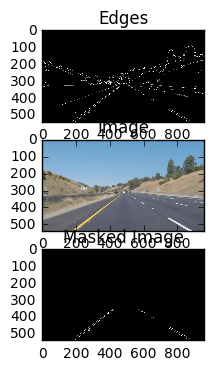

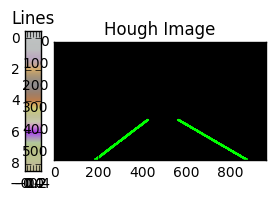

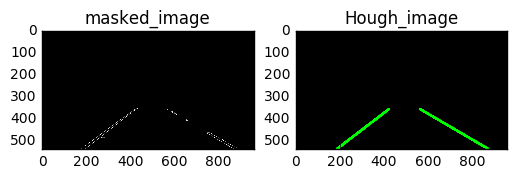

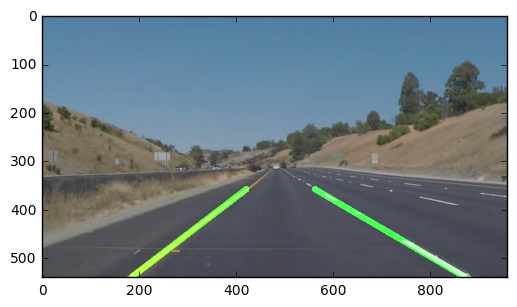

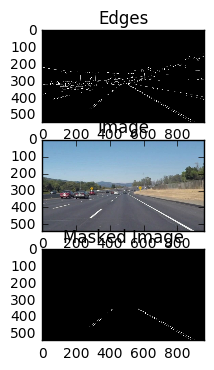

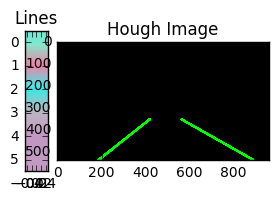

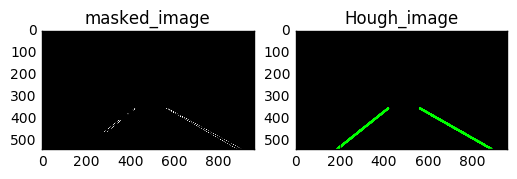

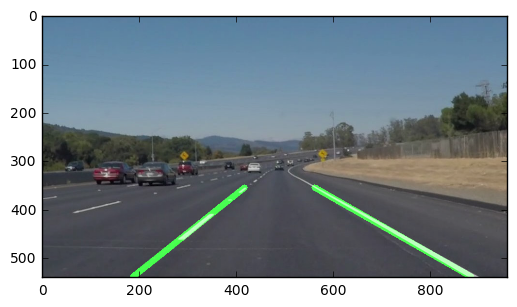

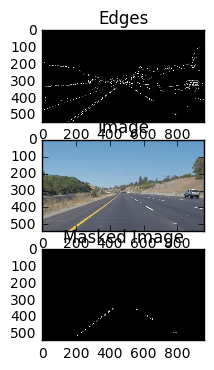

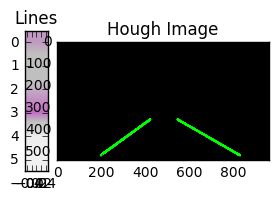

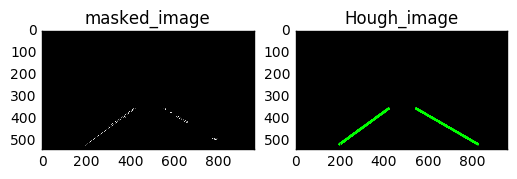

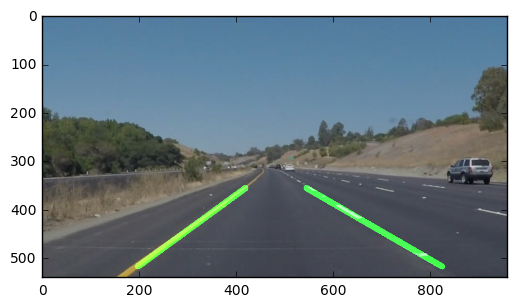

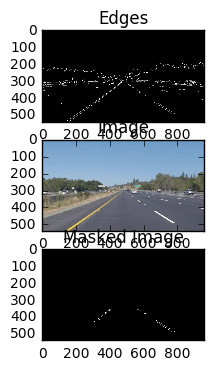

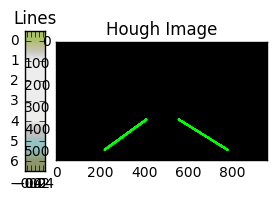

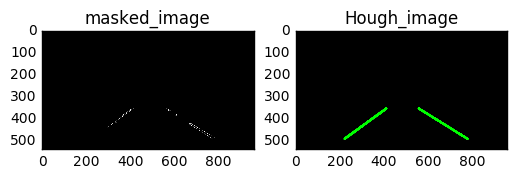

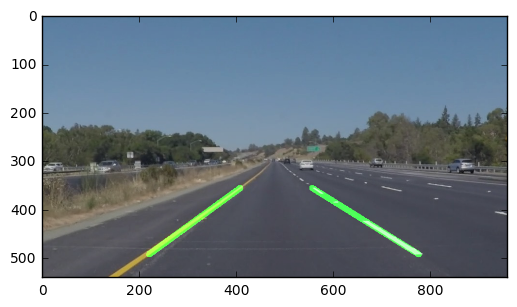

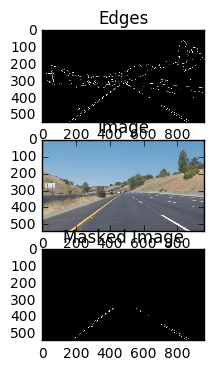

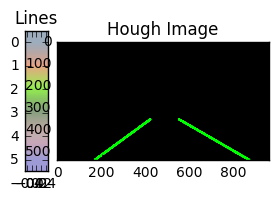

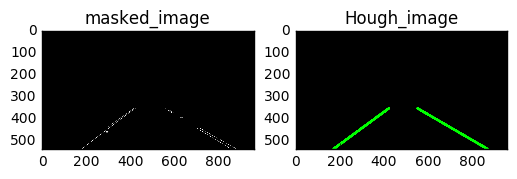

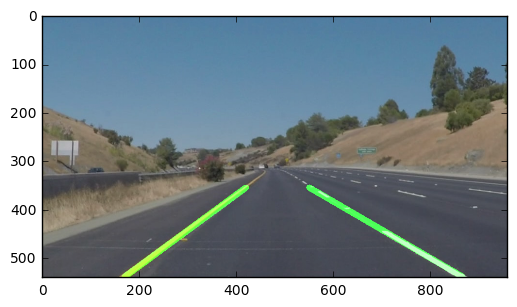

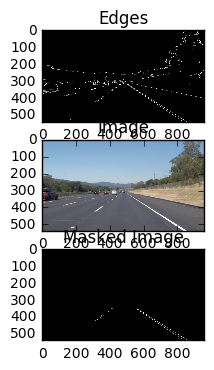

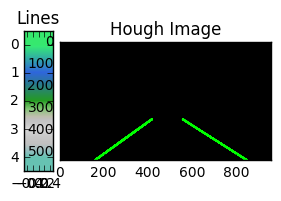

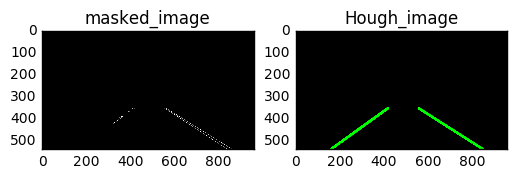

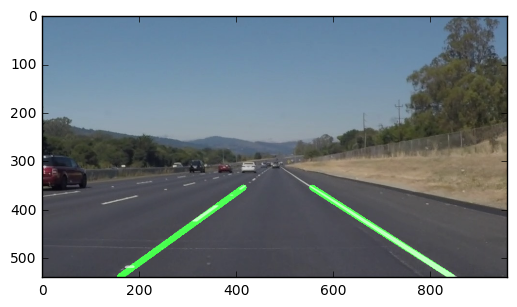

In [12]:
# readAllImages(images)